In [1]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/notebooks

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/notebooks


In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rapids_singlecell as rsc
import random
import pandas as pd
from scipy.stats import pearsonr
import torch

import warnings
warnings.filterwarnings("ignore")

In [3]:
adata = sc.read_h5ad('../Eraslan.h5ad')

In [4]:
adata.layers['counts'] = adata.raw[:, adata.var.index].X.copy()

In [5]:
genes_to_keep = ['TLR5',
 'TLR9',
 'TLR10',
 'TLR1',
 'TLR6',
 'TLR2',
 'TLR3',
 'TLR7',
 'TLR8-AS1',
 'TLR8',
 'TLR4'] + ['RPS4Y1', 'XIST']
genes_to_keep

['TLR5',
 'TLR9',
 'TLR10',
 'TLR1',
 'TLR6',
 'TLR2',
 'TLR3',
 'TLR7',
 'TLR8-AS1',
 'TLR8',
 'TLR4',
 'RPS4Y1',
 'XIST']

In [6]:
# preprocess dataset
adata.X = adata.layers['counts'].copy()
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=False,
    layer="counts",
    flavor="seurat_v3",
)

In [7]:
adata.var['hvg_and_selected'] = adata.var['highly_variable'] | adata.var['gene_name'].isin(genes_to_keep)
adata = adata[:, adata.var['hvg_and_selected'] == True].copy()

In [8]:
adata.var['Ensemble_ID'] = adata.var.index.copy()
adata.var.index = adata.var['gene_name'].copy()

In [9]:
adata.obs['CoarseCellType'] = [ct.split(' (')[0] for ct in adata.obs['Broad cell type']]

In [10]:
def check_difference(adata,  # OOD Adata
                cov_names,
                cov_values: str,
                cov_values_cf: str,):
    adata.X = adata.layers['counts'].copy()
    adata.obs['idx'] = [i for i in range(len(adata))]

    true_indices = pd.DataFrame([adata.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    true_idx = list(adata[true_indices].obs['idx'])
    
    source_indices = pd.DataFrame([adata.obs[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_idx = list(adata[source_indices].obs['idx'])
                    
    # true_idx = list(adata[adata.obs[cov_name] == cov_values_cf].obs['idx'])
    # source_idx = list(adata[adata.obs[cov_name] == cov_values].obs['idx'])

    true_adata = adata[adata.obs['idx'].isin(true_idx)].copy()
    source_adata = adata[adata.obs['idx'].isin(source_idx)].copy()

    # sc.pp.normalize_total(true_adata)
    true_x_count = torch.tensor(true_adata.X.toarray())
    # sc.pp.normalize_total(source_adata)
    cf_x_count = torch.tensor(source_adata.X.toarray())

    x_true = true_x_count
    x_ctrl = cf_x_count

    x_true = np.log1p(x_true)
    x_ctrl = np.log1p(x_ctrl)
    return x_ctrl, x_true

# Scenario 1

In [11]:
# Scenario 1
case_1_ct = [
'Immune (T cell)',
'Immune (NK cell)',
'Immune (DC/macrophage)',
]
split_key = 'split_1'

adata.obs[split_key] = 'train'
test_inds = ((adata.obs['Broad cell type'].isin(case_1_ct)) & 
             (
                 (adata.obs['sex'] == 'male') | 
                 (
                     (adata.obs['sex'] == 'female') & (adata.obs['tissue'] == 'lingula of left lung'))))

adata.obs.loc[test_inds, split_key] = 'test'
non_test_inds = list(adata[(adata.obs[split_key] == 'train')].obs.index)
# Shuffle the list to ensure randomness
random.seed(0)
random.shuffle(non_test_inds)

# Calculate the split size for 10% validation
split_size = int(0.1 * len(non_test_inds))

# Split the indices into training and validation sets
validation_indices = non_test_inds[:split_size]
train_indices = non_test_inds[split_size:]

print("Training Indices:", len(train_indices))
print("Validation Indices:", len(validation_indices))

adata.obs.loc[train_indices, split_key] = 'train'
adata.obs.loc[validation_indices, split_key] = 'val'

Training Indices: 179841
Validation Indices: 19982


In [12]:
adata.obs[split_key].value_counts()

split_1
train    179841
val       19982
test       9303
Name: count, dtype: int64

In [13]:
adata[adata.obs[split_key] == 'test'].obs['Broad cell type'].value_counts()

Broad cell type
Immune (DC/macrophage)    7337
Immune (T cell)           1682
Immune (NK cell)           284
Name: count, dtype: int64

In [14]:
adata[adata.obs[split_key] == 'test'].obs['sex'].value_counts()

sex
male      8457
female     846
Name: count, dtype: int64

In [15]:
adata[adata.obs[split_key] == 'test'].obs['tissue'].value_counts()

tissue
anterior wall of left ventricle    3734
prostate gland                     1664
esophagus muscularis mucosa        1610
lingula of left lung               1590
gastrocnemius                       511
skin of leg                         194
Name: count, dtype: int64

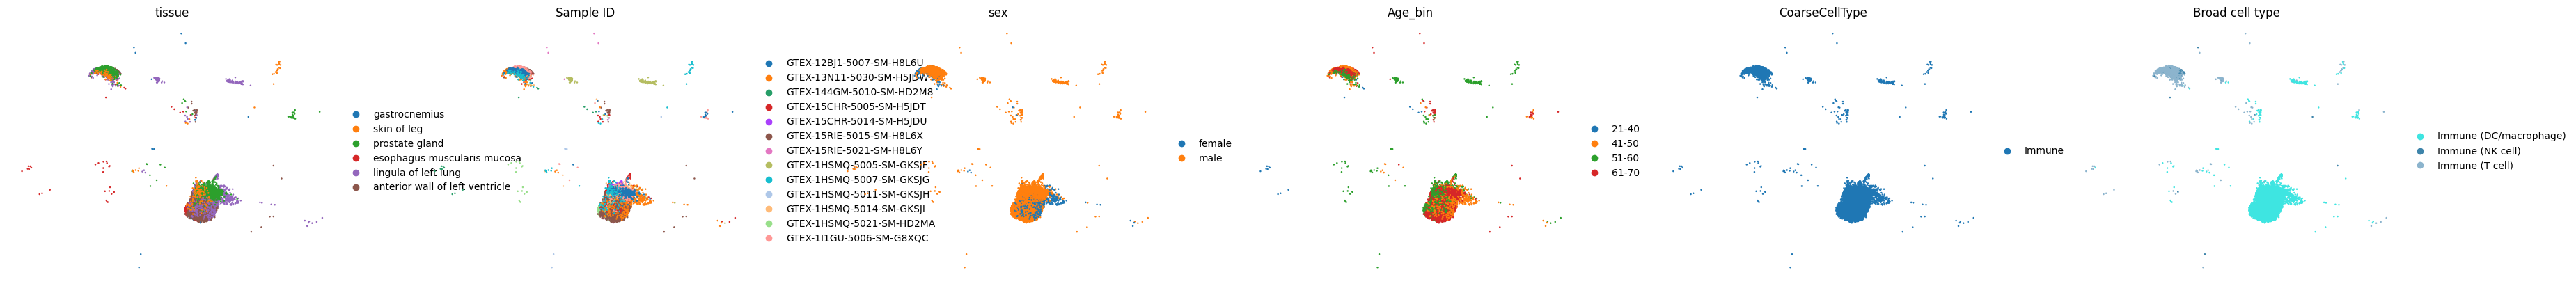

In [16]:
rsc.get.anndata_to_GPU(adata)
rsc.pp.neighbors(adata)
rsc.tl.umap(adata)
rsc.get.anndata_to_CPU(adata)
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType', 'Broad cell type']
sc.pl.umap(
    adata[adata.obs[split_key] == 'test'],
    color=cats,
    ncols=len(cats),
    frameon=False,
    # legend_loc=None,
)

In [17]:
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
adata.obs['cov_sex'] = adata.obs['Broad cell type'].astype(str) + '_' + adata.obs.sex.astype(str)
mt = [gene for gene in adata.var['gene_name'] if gene.startswith('MT-')]
rp = [gene for gene in adata.var['gene_name'] if (gene.startswith('RPL') or gene.startswith('RPS'))]
rp.remove('RPS4Y1')
remove = mt + rp
adata_ = adata[:, ~adata.var['gene_name'].isin(remove)]

adata_ = adata_[(adata_.obs['Broad cell type'].isin(case_1_ct)) & (adata_.obs['tissue'] == 'lingula of left lung')]

groupby='cov_sex'
control_group='female'
covariate='Broad cell type'
key_added="rank_genes_groups_split_1"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
cov_categories = adata_.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # name of the control group in the groupby obs column
    control_group_cov = "_".join([cov_cat, control_group])
    if control_group_cov not in adata_.obs[groupby].values:
        print('Error!\n')
    # subset adata to cells belonging to a covariate category
    adata_cov = adata_[adata_.obs[covariate] == cov_cat]
    
    # compute DEGs
    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )

    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns
    
    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['logfoldchanges']
        
        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)
        
        gene_dict[group] = de_genes[group].tolist()

adata_.uns[key_added] = gene_dict
adata.uns[key_added] = adata_.uns[key_added]
adata.X = adata.layers['counts'].copy()

Immune (DC/macrophage)
Immune (T cell)
Immune (NK cell)


In [18]:
for group in adata.uns[key_added].keys():
    print(group)
    print(len(adata.uns[key_added][group]))
    print()

Immune (DC/macrophage)_male
59

Immune (T cell)_male
7

Immune (NK cell)_male
0



In [19]:
difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}
for key, degs in adata.uns[key_added].items():
    cell_type_to_check = key.split('_')[0]
    cov_names = ['sex']
    cov_values = ['male' if key.split('_')[1] == 'female' else 'female']
    cov_values_cf = [key.split('_')[1]]
    if len(degs) < 2:
        continue
    x_ctrl, x_true = check_difference(
                adata[adata.obs['Broad cell type'] == cell_type_to_check],
                cov_names,
                cov_values,
                cov_values_cf,)
    degs = np.where(np.isin(adata.var_names, degs))[0]
    x_true_deg = x_true[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]

    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]
    
    difference_dict['Group'].append(key)
    difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
    difference_dict['n_DEGs'].append(len(degs))

In [20]:
difference_dict_1 = difference_dict.copy()
difference_df_1 = pd.DataFrame(difference_dict_1)
difference_df_1

,Group,Correlation with control,n_DEGs
0,Immune (DC/macrophage)_male,0.79,59
1,Immune (T cell)_male,0.24,7


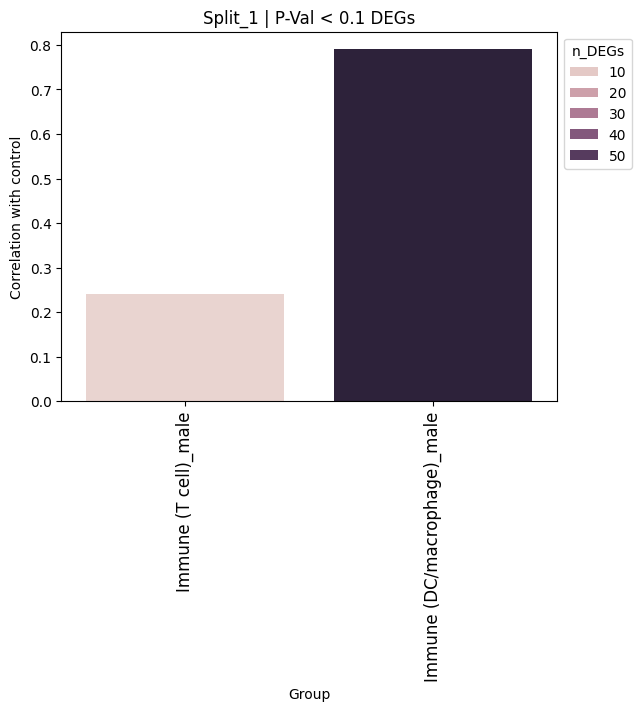

In [21]:
ax = sns.barplot(difference_df_1.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Split_1 | P-Val < 0.1 DEGs')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, fontsize=12)
plt.show()

# Scenario 2

In [22]:
# Scenario 2
case_2_ct = 'Epithelial cell (luminal)'
split_key = 'split_2'

adata.obs[split_key] = 'train'
test_inds = adata.obs['Broad cell type'] == case_2_ct

adata.obs.loc[test_inds, split_key] = 'test'
non_test_inds = list(adata[(adata.obs[split_key] == 'train')].obs.index)
# Shuffle the list to ensure randomness
random.seed(0)
random.shuffle(non_test_inds)

# Calculate the split size for 10% validation
split_size = int(0.1 * len(non_test_inds))

# Split the indices into training and validation sets
validation_indices = non_test_inds[:split_size]
train_indices = non_test_inds[split_size:]

print("Training Indices:", len(train_indices))
print("Validation Indices:", len(validation_indices))

adata.obs.loc[train_indices, split_key] = 'train'
adata.obs.loc[validation_indices, split_key] = 'val'

Training Indices: 173853
Validation Indices: 19317


In [23]:
adata.obs[split_key].value_counts()

split_2
train    173853
val       19317
test      15956
Name: count, dtype: int64

In [24]:
adata[adata.obs[split_key] == 'test'].obs['Broad cell type'].value_counts()

Broad cell type
Epithelial cell (luminal)    15956
Name: count, dtype: int64

In [25]:
adata[adata.obs[split_key] == 'test'].obs['sex'].value_counts()

sex
male      11107
female     4849
Name: count, dtype: int64

In [26]:
adata[adata.obs[split_key] == 'test'].obs['tissue'].value_counts()

tissue
prostate gland    11107
breast             4849
Name: count, dtype: int64

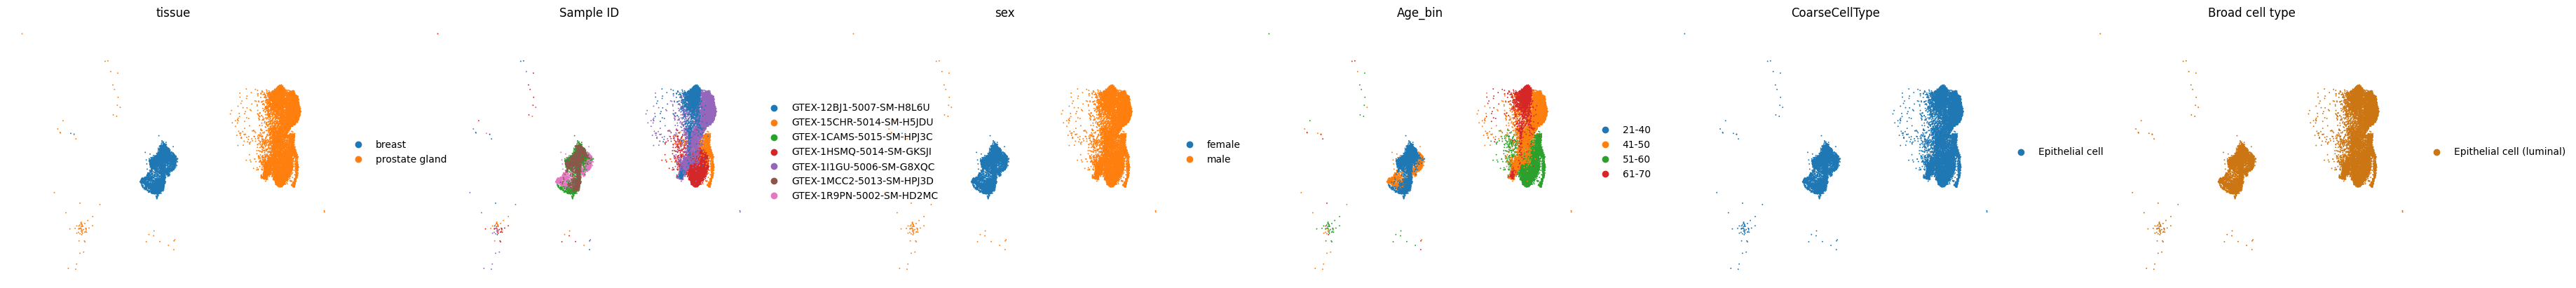

In [27]:
rsc.get.anndata_to_GPU(adata)
rsc.pp.neighbors(adata)
rsc.tl.umap(adata)
rsc.get.anndata_to_CPU(adata)
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType', 'Broad cell type']
sc.pl.umap(
    adata[adata.obs[split_key] == 'test'],
    color=cats,
    ncols=len(cats),
    frameon=False,
    # legend_loc=None,
)

In [28]:
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
adata.obs['sex_tissue'] = adata.obs['sex'].astype(str) + '_' + adata.obs.tissue.astype(str)
mt = [gene for gene in adata.var['gene_name'] if gene.startswith('MT-')]
rp = [gene for gene in adata.var['gene_name'] if (gene.startswith('RPL') or gene.startswith('RPS'))]
rp.remove('RPS4Y1')
remove = mt + rp
adata_ = adata[:, ~adata.var['gene_name'].isin(remove)]

adata_ = adata_[adata_.obs['Broad cell type'] == case_2_ct]

groupby='sex_tissue'
control_group='female_breast'
key_added="rank_genes_groups_split_2"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}

sc.tl.rank_genes_groups(
    adata_,
    groupby=groupby,
    reference=control_group,
    rankby_abs=rankby_abs,
    n_genes=n_genes,
    use_raw=False,
    method='wilcoxon',
)

de_genes_groups = pd.DataFrame(adata_.uns["rank_genes_groups"]["names"]).columns

de_genes = {}
lfc = {}
for group in de_genes_groups:
    # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
    de_genes[group] = sc.get.rank_genes_groups_df(adata_, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['names']
    lfc[group] = sc.get.rank_genes_groups_df(adata_, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['logfoldchanges']

    lfc_indices = lfc[group].abs().sort_values(ascending=False).index
    de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)

    gene_dict[group] = de_genes[group].tolist()

adata_.uns[key_added] = gene_dict
adata.uns[key_added] = adata_.uns[key_added]
adata.X = adata.layers['counts'].copy()

In [29]:
for group in adata.uns[key_added].keys():
    print(group)
    print(len(adata.uns[key_added][group]))
    print()

male_prostate gland
200



In [30]:
difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}
for key, degs in adata.uns[key_added].items():
    cell_type_to_check = 'Epithelial cell (luminal)'
    cov_names = ['sex', 'tissue']
    cov_values = ['female', 'breast']
    cov_values_cf = ['male', 'prostate gland']
    if len(degs) < 2:
        continue
    x_ctrl, x_true = check_difference(
                adata[adata.obs['Broad cell type'] == cell_type_to_check],
                cov_names,
                cov_values,
                cov_values_cf,)
    degs = np.where(np.isin(adata.var_names, degs))[0]
    x_true_deg = x_true[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]

    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]
    
    difference_dict['Group'].append(key)
    difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
    difference_dict['n_DEGs'].append(len(degs))

In [31]:
difference_dict_2 = difference_dict.copy()
difference_df_2 = pd.DataFrame(difference_dict_2)
difference_df_2

,Group,Correlation with control,n_DEGs
0,male_prostate gland,-0.01,200


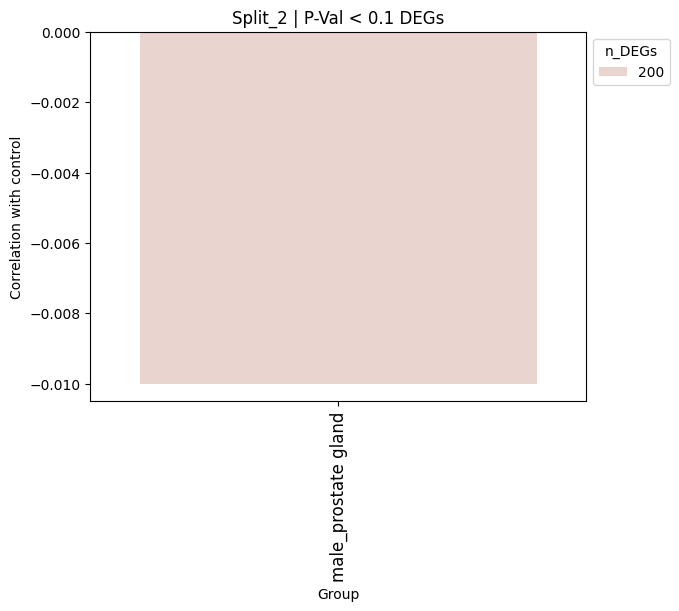

In [32]:
ax = sns.barplot(difference_df_2.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Split_2 | P-Val < 0.1 DEGs')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, fontsize=12)
plt.show()

# Scenario 3

In [33]:
# Scenario 3
split_key = 'split_3'

adata.obs[split_key] = 'train'
test_inds = (adata.obs['sex'] == 'male')

adata.obs.loc[test_inds, split_key] = 'test'
non_test_inds = list(adata[(adata.obs[split_key] == 'train')].obs.index)
# Shuffle the list to ensure randomness
random.seed(0)
random.shuffle(non_test_inds)

# Calculate the split size for 10% validation
split_size = int(0.1 * len(non_test_inds))

# Split the indices into training and validation sets
validation_indices = non_test_inds[:split_size]
train_indices = non_test_inds[split_size:]

print("Training Indices:", len(train_indices))
print("Validation Indices:", len(validation_indices))

adata.obs.loc[train_indices, split_key] = 'train'
adata.obs.loc[validation_indices, split_key] = 'val'

Training Indices: 86141
Validation Indices: 9571


In [34]:
adata.obs[split_key].value_counts()

split_3
test     113414
train     86141
val        9571
Name: count, dtype: int64

In [35]:
adata[adata.obs[split_key] == 'test'].obs['Broad cell type'].value_counts()

Broad cell type
Fibroblast                                   15765
Myocyte (sk. muscle)                         12710
Myocyte (smooth muscle)                      12119
Epithelial cell (luminal)                    11107
Endothelial cell (vascular)                  10170
Epithelial cell (alveolar type II)            8604
Epithelial cell (basal)                       7384
Immune (DC/macrophage)                        6859
Epithelial cell (alveolar type I)             5048
Immune (alveolar macrophage)                  3659
Epithelial cell (club)                        3376
Pericyte/SMC                                  2020
Endothelial cell (lymphatic)                  1971
Myocyte (cardiac)                             1758
Epithelial cell (Hillock)                     1578
Immune (T cell)                               1337
Epithelial cell (basal keratinocyte)          1312
Schwann cell                                   880
Myocyte (cardiac, cytoplasmic)                 733
Immune (mast ce

In [36]:
adata[adata.obs[split_key] == 'test'].obs['sex'].value_counts()

sex
male    113414
Name: count, dtype: int64

In [37]:
adata[adata.obs[split_key] == 'test'].obs['tissue'].value_counts()

tissue
prostate gland                     31061
esophagus muscularis mucosa        24889
lingula of left lung               22024
gastrocnemius                      18372
anterior wall of left ventricle    12067
skin of leg                         5001
Name: count, dtype: int64

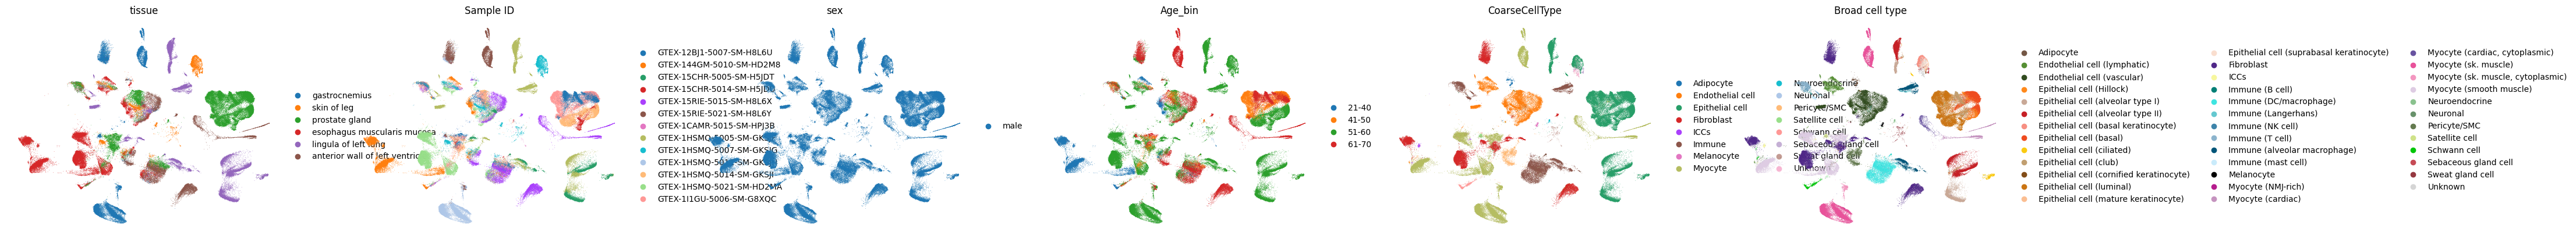

In [38]:
rsc.get.anndata_to_GPU(adata)
rsc.pp.neighbors(adata)
rsc.tl.umap(adata)
rsc.get.anndata_to_CPU(adata)
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType', 'Broad cell type']
sc.pl.umap(
    adata[adata.obs[split_key] == 'test'],
    color=cats,
    ncols=len(cats),
    frameon=False,
    # legend_loc=None,
)

In [39]:
case_3_ct = ['Immune (alveolar macrophage)', 'Epithelial cell (alveolar type II)', 'Epithelial cell (alveolar type I)']

In [40]:
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
mt = [gene for gene in adata.var['gene_name'] if gene.startswith('MT-')]
rp = [gene for gene in adata.var['gene_name'] if (gene.startswith('RPL') or gene.startswith('RPS'))]
rp.remove('RPS4Y1')
remove = mt + rp
adata_ = adata[:, ~adata.var['gene_name'].isin(remove)]

adata_ = adata_[(adata_.obs['Broad cell type'].isin(case_3_ct)) & 
                (adata.obs['sex'] == 'male') & 
                (adata.obs['tissue'] == 'lingula of left lung')]

groupby='Broad cell type'
control_group='Immune (alveolar macrophage)'
key_added="rank_genes_groups_split_3"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}

sc.tl.rank_genes_groups(
    adata_,
    groupby=groupby,
    reference=control_group,
    rankby_abs=rankby_abs,
    n_genes=n_genes,
    use_raw=False,
    method='wilcoxon',
)

de_genes_groups = pd.DataFrame(adata_.uns["rank_genes_groups"]["names"]).columns

de_genes = {}
lfc = {}
for group in de_genes_groups:
    # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
    de_genes[group] = sc.get.rank_genes_groups_df(adata_, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['names']
    lfc[group] = sc.get.rank_genes_groups_df(adata_, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['logfoldchanges']

    lfc_indices = lfc[group].abs().sort_values(ascending=False).index
    de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)

    gene_dict[group] = de_genes[group].tolist()

adata_.uns[key_added] = gene_dict
adata.uns[key_added] = adata_.uns[key_added]
adata.X = adata.layers['counts'].copy()

In [41]:
for group in adata.uns[key_added].keys():
    print(group)
    print(len(adata.uns[key_added][group]))
    print()

Epithelial cell (alveolar type I)
200

Epithelial cell (alveolar type II)
200



In [42]:
difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}
for key, degs in adata.uns[key_added].items():
    cov_names = ['Broad cell type']
    cov_values = ['Immune (alveolar macrophage)']
    cov_values_cf = [key]
    if len(degs) < 2:
        continue
    x_ctrl, x_true = check_difference(
                adata[(adata.obs['Broad cell type'].isin(case_3_ct)) &
                      (adata.obs['sex'] == 'male') & 
                      (adata.obs['tissue'] == 'lingula of left lung')],
                cov_names,
                cov_values,
                cov_values_cf,)
    degs = np.where(np.isin(adata.var_names, degs))[0]
    x_true_deg = x_true[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]

    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]
    
    difference_dict['Group'].append(key)
    difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
    difference_dict['n_DEGs'].append(len(degs))

In [43]:
difference_dict_3 = difference_dict.copy()
difference_df_3 = pd.DataFrame(difference_dict_3)
difference_df_3

,Group,Correlation with control,n_DEGs
0,Epithelial cell (alveolar type I),0.06,200
1,Epithelial cell (alveolar type II),0.08,200


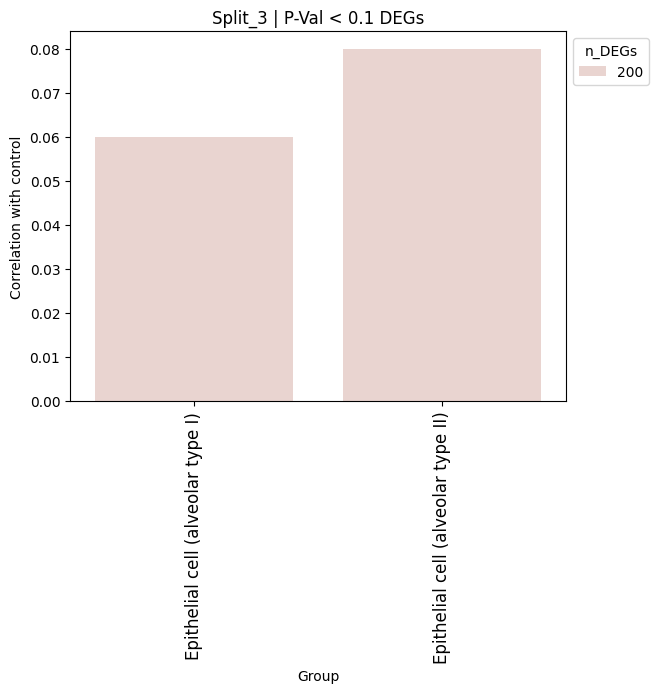

In [44]:
ax = sns.barplot(difference_df_3.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Split_3 | P-Val < 0.1 DEGs')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, fontsize=12)
plt.show()

# Scenario 4

In [45]:
# Scenario 4
split_key = 'split_4'

adata.obs[split_key] = 'train'
test_inds = (adata.obs['sex'] == 'male')

adata.obs.loc[test_inds, split_key] = 'test'
non_test_inds = list(adata[(adata.obs[split_key] == 'train')].obs.index)
# Shuffle the list to ensure randomness
random.seed(0)
random.shuffle(non_test_inds)

# Calculate the split size for 10% validation
split_size = int(0.1 * len(non_test_inds))

# Split the indices into training and validation sets
validation_indices = non_test_inds[:split_size]
train_indices = non_test_inds[split_size:]

print("Training Indices:", len(train_indices))
print("Validation Indices:", len(validation_indices))

adata.obs.loc[train_indices, split_key] = 'train'
adata.obs.loc[validation_indices, split_key] = 'val'

Training Indices: 86141
Validation Indices: 9571


In [46]:
adata.obs[split_key].value_counts()

split_4
test     113414
train     86141
val        9571
Name: count, dtype: int64

In [47]:
adata[adata.obs[split_key] == 'test'].obs['Broad cell type'].value_counts()

Broad cell type
Fibroblast                                   15765
Myocyte (sk. muscle)                         12710
Myocyte (smooth muscle)                      12119
Epithelial cell (luminal)                    11107
Endothelial cell (vascular)                  10170
Epithelial cell (alveolar type II)            8604
Epithelial cell (basal)                       7384
Immune (DC/macrophage)                        6859
Epithelial cell (alveolar type I)             5048
Immune (alveolar macrophage)                  3659
Epithelial cell (club)                        3376
Pericyte/SMC                                  2020
Endothelial cell (lymphatic)                  1971
Myocyte (cardiac)                             1758
Epithelial cell (Hillock)                     1578
Immune (T cell)                               1337
Epithelial cell (basal keratinocyte)          1312
Schwann cell                                   880
Myocyte (cardiac, cytoplasmic)                 733
Immune (mast ce

In [48]:
adata[adata.obs[split_key] == 'test'].obs['sex'].value_counts()

sex
male    113414
Name: count, dtype: int64

In [49]:
adata[adata.obs[split_key] == 'test'].obs['tissue'].value_counts()

tissue
prostate gland                     31061
esophagus muscularis mucosa        24889
lingula of left lung               22024
gastrocnemius                      18372
anterior wall of left ventricle    12067
skin of leg                         5001
Name: count, dtype: int64

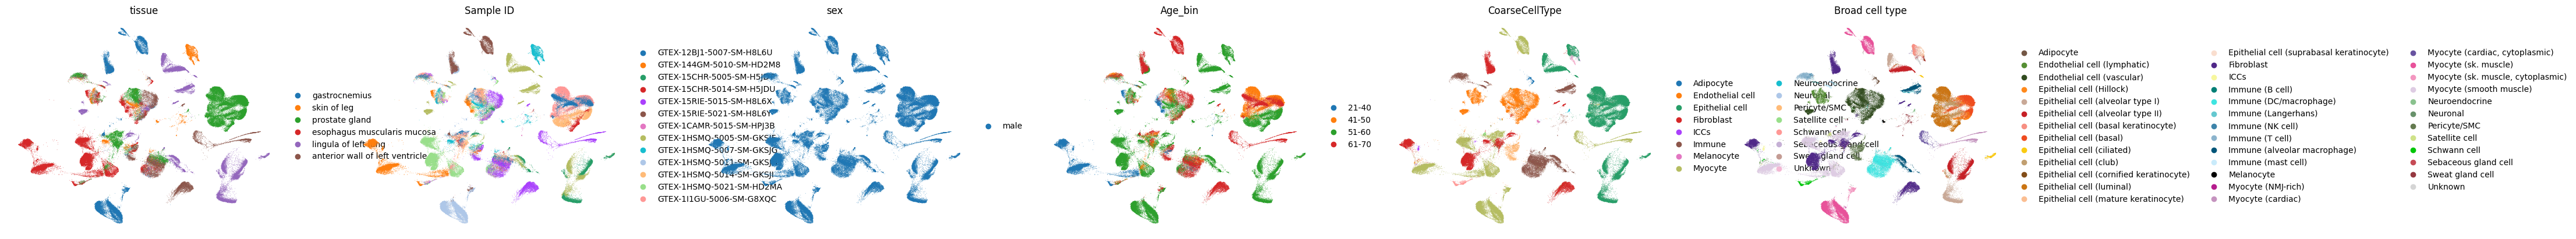

In [50]:
rsc.get.anndata_to_GPU(adata)
rsc.pp.neighbors(adata)
rsc.tl.umap(adata)
rsc.get.anndata_to_CPU(adata)
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType', 'Broad cell type']
sc.pl.umap(
    adata[adata.obs[split_key] == 'test'],
    color=cats,
    ncols=len(cats),
    frameon=False,
    # legend_loc=None,
)

In [51]:
case_4_ct = ['Immune (alveolar macrophage)', 'Immune (DC/macrophage)']

In [52]:
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
adata.obs['cov_tissue'] = adata.obs['Broad cell type'].astype(str) + '_' + adata.obs.tissue.astype(str)
mt = [gene for gene in adata.var['gene_name'] if gene.startswith('MT-')]
rp = [gene for gene in adata.var['gene_name'] if (gene.startswith('RPL') or gene.startswith('RPS'))]
rp.remove('RPS4Y1')
remove = mt + rp
adata_ = adata[:, ~adata.var['gene_name'].isin(remove)]

adata_ = adata_[(adata_.obs['Broad cell type'].isin(case_4_ct)) & 
                (adata.obs['sex'] == 'male')]

groupby='cov_tissue'
control_group='Immune (DC/macrophage)_anterior wall of left ventricle'
key_added="rank_genes_groups_split_4"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}

sc.tl.rank_genes_groups(
    adata_,
    groupby=groupby,
    reference=control_group,
    rankby_abs=rankby_abs,
    n_genes=n_genes,
    use_raw=False,
    method='wilcoxon',
)

de_genes_groups = pd.DataFrame(adata_.uns["rank_genes_groups"]["names"]).columns

de_genes = {}
lfc = {}
for group in de_genes_groups:
    # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
    de_genes[group] = sc.get.rank_genes_groups_df(adata_, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['names']
    lfc[group] = sc.get.rank_genes_groups_df(adata_, group, key='rank_genes_groups', pval_cutoff=0.1, log2fc_min=None, log2fc_max=None)['logfoldchanges']

    lfc_indices = lfc[group].abs().sort_values(ascending=False).index
    de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)

    gene_dict[group] = de_genes[group].tolist()

adata_.uns[key_added] = gene_dict
adata.uns[key_added] = adata_.uns[key_added]
adata.X = adata.layers['counts'].copy()

In [53]:
for group in adata.uns[key_added].keys():
    print(group)
    print(len(adata.uns[key_added][group]))
    print()

Immune (DC/macrophage)_esophagus muscularis mucosa
95

Immune (DC/macrophage)_gastrocnemius
68

Immune (DC/macrophage)_lingula of left lung
84

Immune (DC/macrophage)_prostate gland
152

Immune (DC/macrophage)_skin of leg
40

Immune (alveolar macrophage)_lingula of left lung
200



In [54]:
difference_dict = {'Group': [], 'Correlation with control': [], 'n_DEGs': []}

key = 'Immune (alveolar macrophage)_lingula of left lung'
degs = adata.uns[key_added][key]

cov_names = ['tissue', 'Broad cell type']
cov_values = ['anterior wall of left ventricle', 'Immune (DC/macrophage)']
cov_values_cf = ['lingula of left lung', 'Immune (alveolar macrophage)']
x_ctrl, x_true = check_difference(
            adata[(adata.obs['Broad cell type'].isin(case_4_ct)) &
                  (adata.obs['sex'] == 'male')],
            cov_names,
            cov_values,
            cov_values_cf,)
degs = np.where(np.isin(adata.var_names, degs))[0]
x_true_deg = x_true[:, degs]
x_ctrl_deg = x_ctrl[:, degs]

r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))[0]
r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))[0]

difference_dict['Group'].append(key)
difference_dict['Correlation with control'].append(round(r2_mean_base_deg, 2))
difference_dict['n_DEGs'].append(len(degs))

In [55]:
difference_dict_4 = difference_dict.copy()
difference_df_4 = pd.DataFrame(difference_dict_4)
difference_df_4

,Group,Correlation with control,n_DEGs
0,Immune (alveolar macrophage)_lingula of left lung,0.25,200


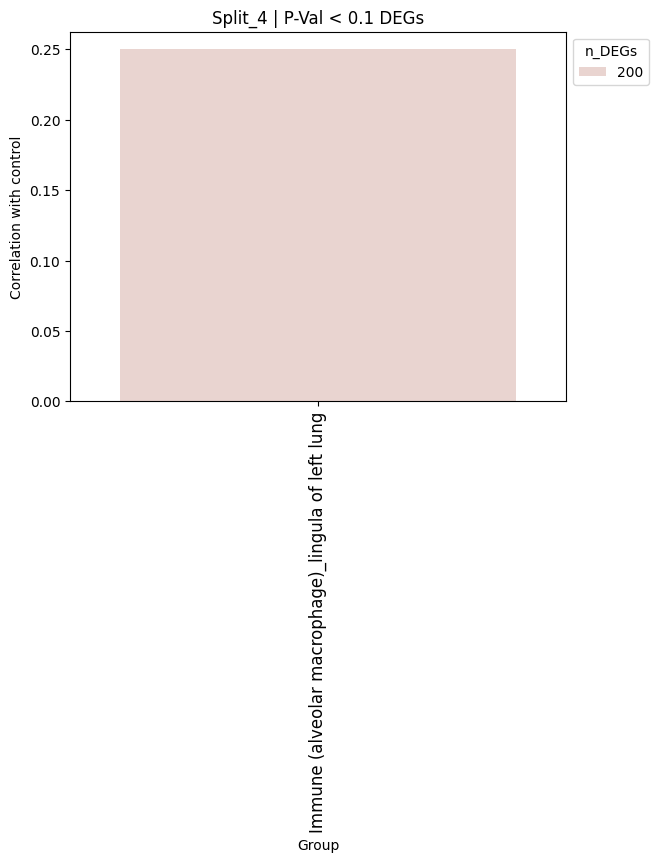

In [56]:
ax = sns.barplot(difference_df_4.sort_values(by='Correlation with control'),
                 x='Group', 
                 y='Correlation with control',
                 hue='n_DEGs',
                 legend='brief',
                 )
ax.set_title('Split_4 | P-Val < 0.1 DEGs')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [57]:
adata

AnnData object with n_obs × n_vars = 209126 × 1212
    obs: 'Sample ID_prep', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID', 'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'channel', 'developme

In [58]:
print(adata.X.min())
print(adata.X.max())
print(adata.layers['counts'].min())
print(adata.layers['counts'].max())

0.0
3370.0
0.0
3370.0


In [59]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [60]:
print(adata.X.min())
print(adata.X.max())
print(adata.layers['counts'].min())
print(adata.layers['counts'].max())

0.0
9.210441
0.0
3370.0


In [61]:
adata.write('../eraslan_preprocessed1212_split_deg.h5ad')